In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import random


In [2]:

def load_images_from_folder(folder, label, img_size=(128, 128)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            old_size = img.shape[:2] # old_size is in (height, width) format
            ratio = float(img_size[0])/max(old_size)
            new_size = tuple([int(x*ratio) for x in old_size])
            img = cv2.resize(img, (new_size[1], new_size[0]))

            delta_w = img_size[1] - new_size[1]
            delta_h = img_size[0] - new_size[0]
            top, bottom = delta_h//2, delta_h-(delta_h//2)
            left, right = delta_w//2, delta_w-(delta_w//2)

            color = [0, 0, 0]
            img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

            images.append(img)
            labels.append(label)
    return images, labels

categories = ['person', 'motorbike', 'fruit', 'flower', 'dog', 'cat', 'car', 'airplane']
base_path = 'natural_images'
img_size = (128, 128)

all_images = []
all_labels = []

for i, category in enumerate(categories):
    folder_path = os.path.join(base_path, category)
    images, labels = load_images_from_folder(folder_path, i, img_size)
    all_images.extend(images)
    all_labels.extend(labels)

all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Normalize the images
all_images = all_images / 255.0

# One-hot encode the labels
all_labels = to_categorical(all_labels, num_classes=len(categories))


In [3]:
#Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)


Labels: ['person', 'motorbike', 'fruit', 'flower', 'dog', 'cat', 'car', 'airplane']


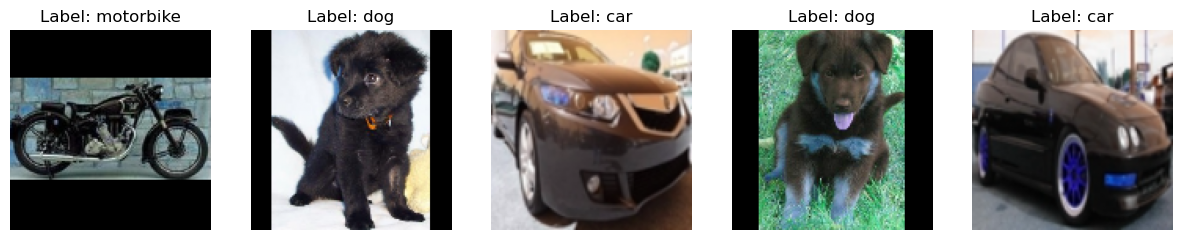

In [4]:
# Print all the labels
print("Labels:", categories)

# Display some images to check normalization
def display_random_images(images, labels, num_images=5):
    indices = random.sample(range(len(images)), num_images)
    plt.figure(figsize=(15, 15))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[idx])
        plt.title(f"Label: {categories[np.argmax(labels[idx])]}")
        plt.axis('off')
    plt.show()

display_random_images(all_images, all_labels)

In [6]:
# Build the CNN model
cnn = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(filters=64, kernel_size=7, activation="relu", padding="same"),  # Convolution 1
    MaxPooling2D(pool_size=2, strides=2),  # Pooling 1
    Conv2D(filters=128, kernel_size=3, activation="relu", padding="same"),  # Convolution 2
    Conv2D(filters=128, kernel_size=3, activation="relu", padding="same"),  # Convolution 3
    MaxPooling2D(pool_size=2, strides=2),  # Pooling 2
    Conv2D(filters=256, kernel_size=3, activation="relu", padding="same"),  # Convolution 4
    Conv2D(filters=256, kernel_size=3, activation="relu", padding="same"),  # Convolution 5
    MaxPooling2D(pool_size=2, strides=2),  # Pooling 3
    Flatten(),  # Flattening
    Dense(units=128, activation="relu"),  # Full Connection 1
    Dropout(0.5),
    Dense(units=64, activation="relu"),  # Full Connection 2
    Dropout(0.5),
    Dense(units=len(categories), activation="softmax")  # Output layer
])

# Print the model summary
cnn.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,513,672 (36.29 MB)

 Trainable params: 9,513,672 (36.29 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = cnn.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.3204 - loss: 1.7927 - val_accuracy: 0.7913 - val_loss: 0.5604
Epoch 2/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.7037 - loss: 0.7977 - val_accuracy: 0.8159 - val_loss: 0.4097
Epoch 3/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 247s 1s/step - accuracy: 0.7590 - loss: 0.5864 - val_accuracy: 0.8116 - val_loss: 0.4178
Epoch 4/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - accuracy: 0.7839 - loss: 0.5097 - val_accuracy: 0.8232 - val_loss: 0.3882
Epoch 5/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 255s 1s/step - accuracy: 0.7937 - loss: 0.4837 - val_accuracy: 0.8333 - val_loss: 0.3706
Epoch 6/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.8163 - loss: 0.4068 - val_accuracy: 0.8558 - val_loss: 0.3578
Epoch 7/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.8248 - loss: 0.4061 - val_accuracy: 0.8522 - val_loss: 0.3303
Epoch 8/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.8399 - loss: 0.3835 - val_accu

In [10]:
test_loss, test_acc = cnn.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")


44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 351ms/step - accuracy: 0.8844 - loss: 0.3279
Test accuracy: 0.8826087117195129
Test loss: 0.3143197000026703


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


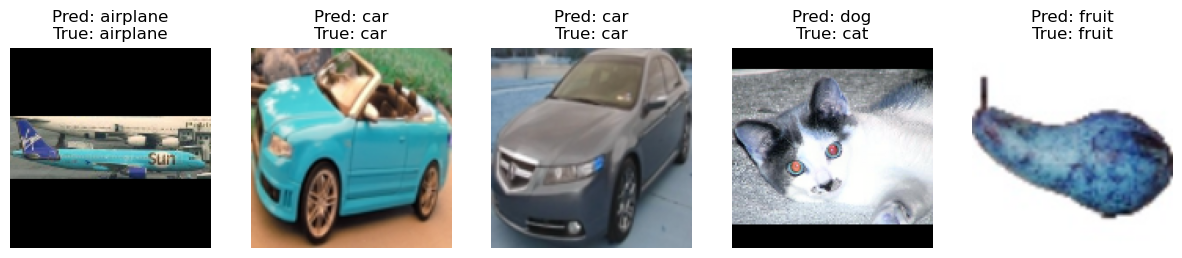

In [14]:
# Select some random test images
num_test_images = 5
random_indices = random.sample(range(len(X_test)), num_test_images)
test_images = X_test[random_indices]
test_labels = y_test[random_indices]

# Make predictions on the test images
predictions = cnn.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Map numeric labels to category names
label_map = {i: category for i, category in enumerate(categories)}

# Display the images along with the predicted and true labels
plt.figure(figsize=(15, 15))
for i in range(num_test_images):
    plt.subplot(1, num_test_images, i + 1)
    plt.imshow(test_images[i])
    plt.title(f"Pred: {label_map[predicted_labels[i]]}\nTrue: {label_map[true_labels[i]]}")
    plt.axis('off')
plt.show()
